# Model Building

The purpose of this notebook is to build some models that will determine whether a player is over or under paid. Because Machine Learning techniques can't do us any good in our attempt to establish value (i.e. what a player *ought* to be paid), we will use them to predict team wins or a player's individual 'winshare'. 

### Imports

In [304]:
# import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [305]:
from matplotlib import rcParams
import matplotlib as mpl

blue = '#3498DB'
gray = '#95A5A6'
red = '#E74C3C'
dark_gray = '#34495E'
green = '#2ECC71'
purple = '#9B59B6'
flatui = [blue, gray, red, dark_gray, green, purple]

# Patches
mpl.rc('patch', 
       linewidth=0.5, 
       facecolor=dark_gray, 
       edgecolor='w', 
       force_edgecolor=True, 
       antialiased=True)    
  
# Figure
mpl.rc('figure', 
       figsize= (10, 6),
       facecolor='w', 
       edgecolor='w', 
       titlesize='xx-large',
       titleweight=700)

# Grid
mpl.rc('grid', 
       color=dark_gray,
       alpha=0.5, 
       linewidth=0.5, 
       linestyle='-')

# Axes
mpl.rc('axes', 
       facecolor='w',
       edgecolor=dark_gray,
       linewidth=0.5,
       grid=True,
       titlesize='large',
       labelsize='large',
       labelcolor=dark_gray,
       axisbelow=True)

mpl.rc('axes.spines',
       right=False,
       top=False)

# Ticks
mpl.rc('xtick', 
       direction='out',
       color=dark_gray)

mpl.rc('xtick.major', 
       size=0.0)

mpl.rc('xtick.minor', 
       size=0.0)

mpl.rc('ytick', 
       direction='out',
       color=dark_gray)

mpl.rc('ytick.major', 
       size=0.0)

mpl.rc('ytick.minor', 
       size=0.0)

mpl.rc('legend', 
       frameon=False,
       numpoints=1,
       scatterpoints=1)

mpl.rc('font', 
       size=13,
       weight=400,
       family='sans-serif')

rcParams['font.sans-serif']: ['Helvetica', 'Verdana', 'Lucida Grande']

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

## Data

In [306]:
df = pd.read_csv('data/processed/players_final.csv')

df = df[(df.salary.notnull())&(df['Last Name'].notnull())&(df['Dist.'].notnull())]


In [307]:
df.shape

(6193, 75)

# 1 Winshare (WS) Contribution

Summary of Winshare Contribution model here.

In [308]:
from lib.modeling import ws_assessment

ws_assessment(year = 2018).head()

Salary cap for 2018:	 101869000


,Full Name,Tm,W,L,salary,burden,cluster,WS,exp_WS,overpaid
1674,Stephen Curry,GSW,57,25,37457154.0,0.306,Combo Guard,9.7,13.5,True
8,Russell Westbrook,OKC,49,33,35665000.0,0.292,Floor General,6.8,12.8,True
1002,LeBron James,LAL,37,45,35654150.0,0.292,Combo Guard,7.2,12.8,True
530,Chris Paul,HOU,53,29,35654150.0,0.292,Floor General,6.6,12.8,True
679,Kyle Lowry,TOR,58,24,32700000.0,0.268,Combo Guard,6.6,11.8,True


# 2 Cluster-specific Feature Percentiles

Summary of Percentile assessment here.

In [309]:
from lib.modeling import cluster_compare
df.columns

Index(['Full Name', 'Pos', 'cluster', 'index', 'Last Name', 'First Name', 'Year', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'salary', 'Dist.', '2P_A', '0-3_A', '3-10_A', '10-16_A', '16-3pt_A', '3P_A',
       '0-3%', '3-10%', '10-16%', '16-3pt%', 'Astd_2P', 'Dunk%', 'Dunks_Md', 'Astd_3P', '%Corner3_A', 'Corner_3P%', 'Heaves_A', 'Heaves_Md'],
      dtype='object')

C:\Users\gcox3\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


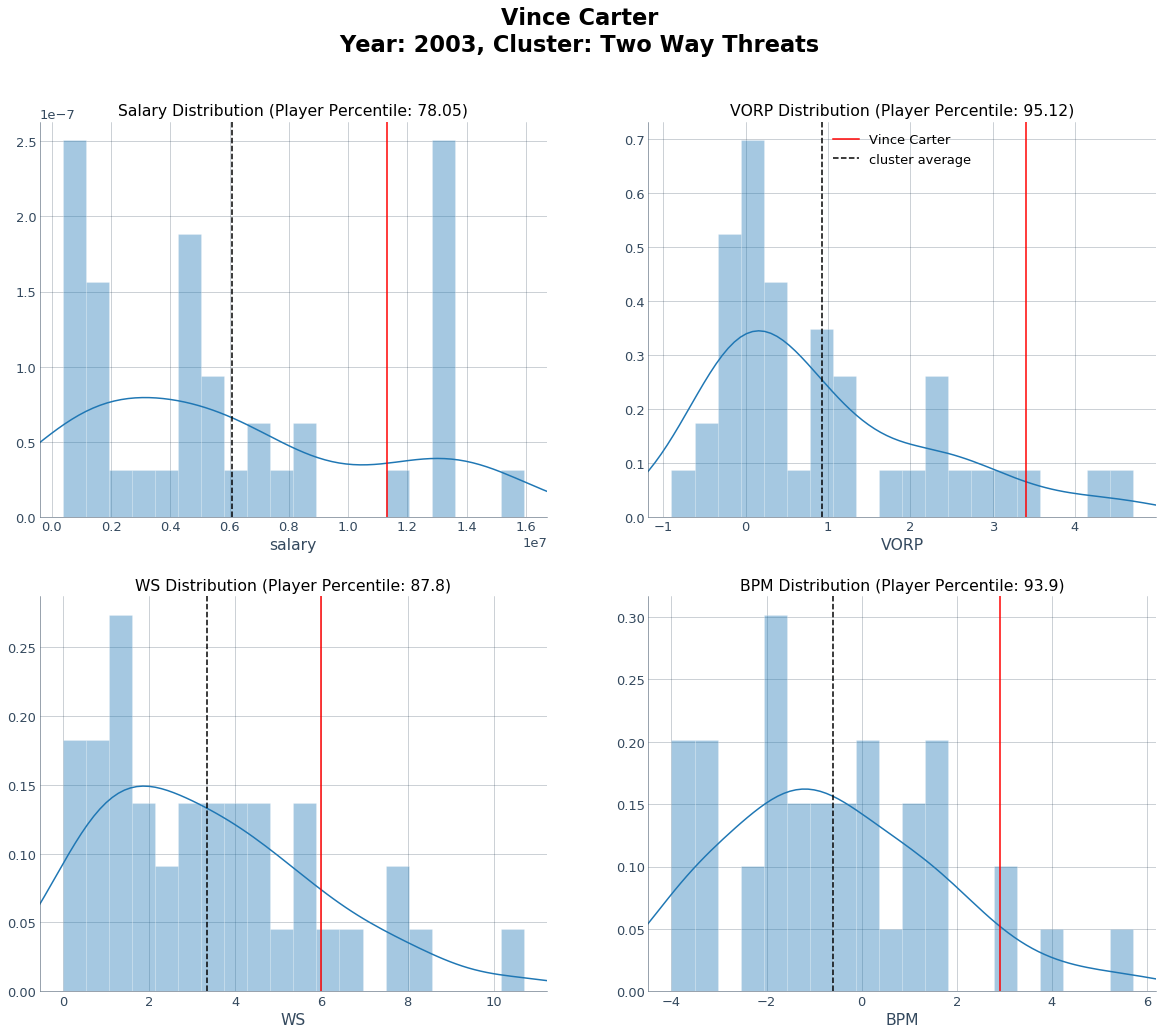

In [310]:
cluster_compare(player = 'Vince Carter', year = 2003)

# 3 Salary Regression Analysis

In [311]:
df = df[df.Year > 2008]

In [312]:
grouped_df = df.groupby('Full Name').mean()

grouped_df.salary.describe()

count    5.170000e+02
mean     5.760784e+06
std      4.393054e+06
min      6.177500e+04
25%      2.275023e+06
50%      4.484295e+06
75%      8.139294e+06
max      2.569816e+07
Name: salary, dtype: float64

In [313]:
rich = df[df.salary >= 0.4*max(df.salary)]
len(rich)

405

In [314]:
df.corr().sort_values('salary', ascending = False).loc[:,'salary'][:14]
cor_target = abs(df.corr()['salary'])
high_cors = cor_target[cor_target > 0.3]
list(high_cors.index)

['GS',
 'MP',
 'FG',
 'FGA',
 '2P',
 'FT',
 'FTA',
 'PTS',
 'PER',
 'USG%',
 'OWS',
 'DWS',
 'WS',
 'WS/48',
 'OBPM',
 'BPM',
 'VORP',
 'salary']

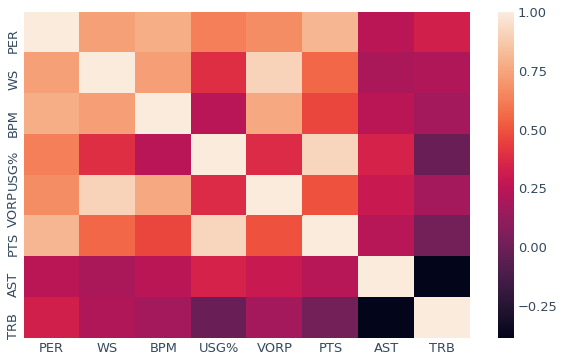

In [315]:
sns.heatmap(df[['PER','WS','BPM','USG%','VORP','PTS','AST','TRB']].corr())

## 3.1 Ordinary Least Squares Regression

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     122.1
Date:                Thu, 19 Sep 2019   Prob (F-statistic):           2.84e-95
Time:                        14:33:15   Log-Likelihood:                -8410.7
No. Observations:                 517   AIC:                         1.684e+04
Df Residuals:                     510   BIC:                         1.687e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.272e+08   1.48e+08      0.859      0.3

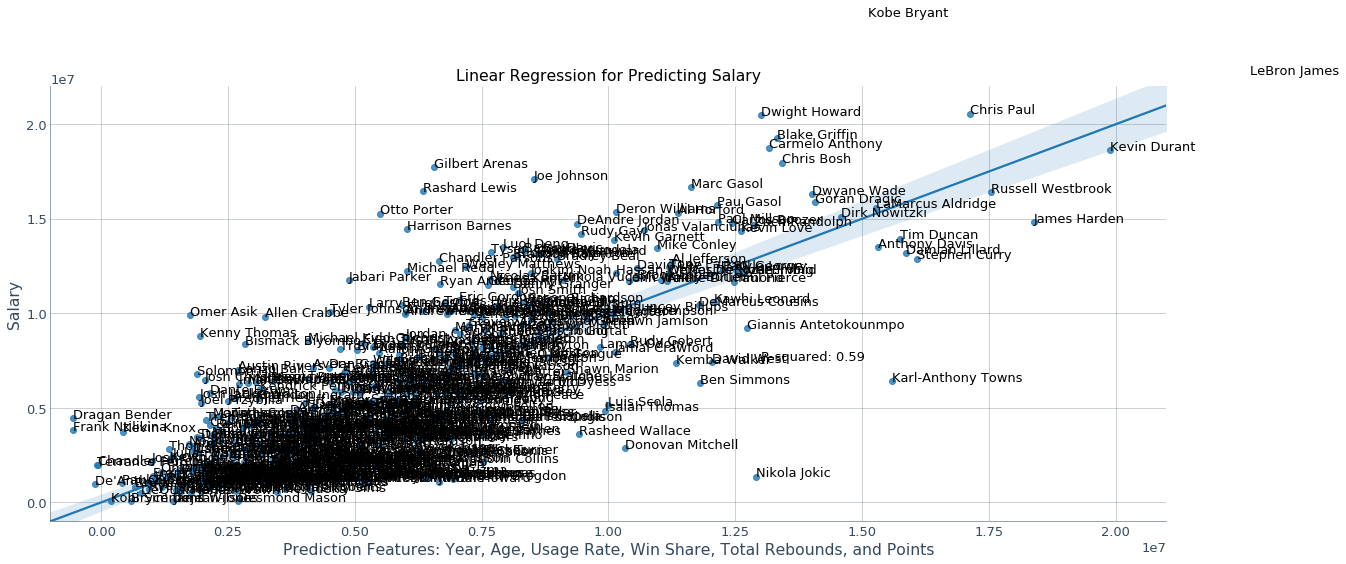

In [316]:
data = grouped_df

data.rename(columns = {'USG%':'USG', 
                       '3P':'Threes',
                       '3PAr':'ThreeAttemptRate'} , inplace = True)

m_1 = ols('salary ~ Age + PTS + TRB + AST + VORP + WS + USG + PER + BPM + Threes + ThreeAttemptRate', data).fit()

# second model uses offensive statistics only
m_2 = ols('salary ~ Age + PTS + AST + ORB + OWS + OBPM + ORtg + TOV + USG + Threes', data).fit()

# third model uses defensive staistics only
m_3 = ols('salary ~ Age + DRB + DWS + DBPM + DRtg + STL + BLK', data).fit()

# final model attempting to reduce input features and to remove negative coefficients
m_4 = ols('salary ~ Year + Age + USG + WS + TRB + PTS', data = data).fit()

model = m_4

print(model.summary())

plt.figure(figsize = (20,8))
sns.regplot(x = model.fittedvalues, y = 'salary', data = data, fit_reg = True)

for name in range(0,grouped_df.shape[0]):
    plt.text(model.fittedvalues[name], data.salary[name], data.index[name])

plt.ylabel('Salary')
plt.xlabel('Prediction Features: Year, Age, Usage Rate, Win Share, Total Rebounds, and Points')
plt.title('Linear Regression for Predicting Salary')
plt.text(1.3e7, 7.5e6, 'R-squared: {}'.format(round(model.rsquared,3)))
plt.ylim([-0.1e7, 2.2e7])
plt.xlim([-0.1e7, 2.1e7])
plt.savefig('assets/linreg.png')

plt.show()

Even the best ols models are very weak (R-squared) when we look at every individual player/season. For example, the model used in the above groupby dataframe produces an R-squared of 0.388 when applied to the full data (every player/season, 20000 records). When we try to strengthen the model by adding features, we still only achieve a poor R-squared of 0.421.

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     109.8
Date:                Thu, 19 Sep 2019   Prob (F-statistic):               0.00
Time:                        14:33:21   Log-Likelihood:                -57943.
No. Observations:                3452   AIC:                         1.159e+05
Df Residuals:                    3427   BIC:                         1.161e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -8.157e+08   6.58e+07    -

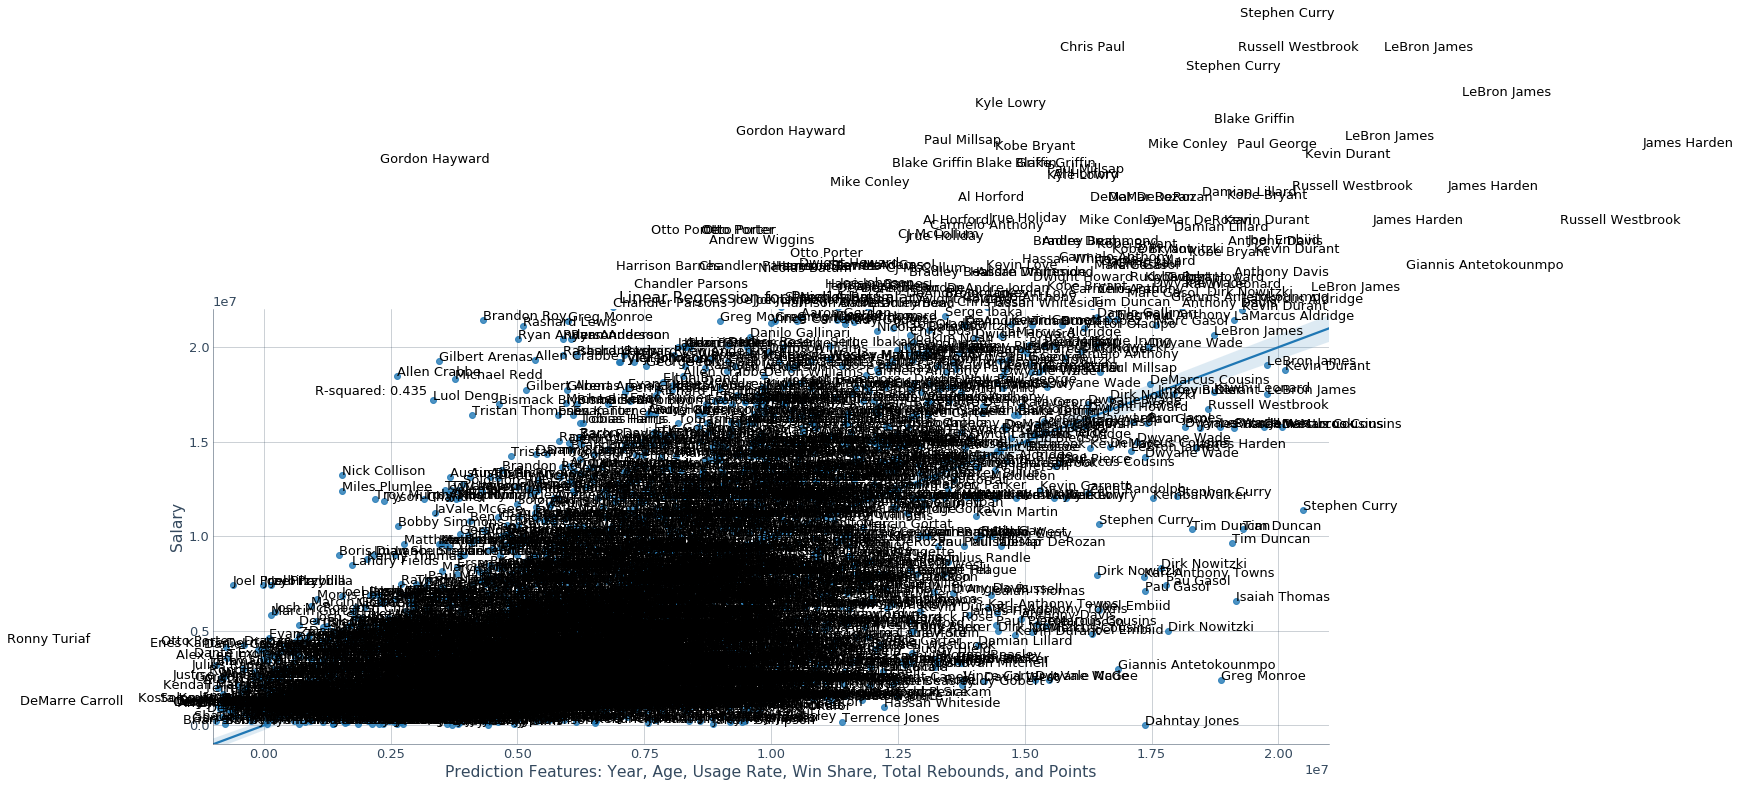

In [317]:
data = df.reset_index()

data.rename(columns={'USG%': 'USG',
                     '3P': 'Threes',
                     '3PAr': 'ThreeAttemptRate',
                     'WS/48': 'winsh_foureight',
                     '2P': 'Made_twos',
                     '2PA': 'Attempted_twos',
                     'TS%': 'True_percent',
                     'AST%': 'Ast_percent'}, inplace=True)

m_1 = ols('salary ~ Age + PTS + TRB + AST + VORP + WS + USG + PER + BPM + Threes + ThreeAttemptRate', data).fit()

# second model uses offensive statistics only
m_2 = ols('salary ~ Age + PTS + AST + ORB + OWS + OBPM + ORtg + TOV + USG + Threes', data).fit()

# third model uses defensive staistics only
m_3 = ols('salary ~ Age + DRB + DWS + DBPM + DRtg + STL + BLK', data).fit()

# final model attempting to reduce input features and to remove negative coefficients
m_4 = ols('salary ~ Year + Age + USG + WS + TRB + PTS', data=data).fit()

# dumped way too much in just to see what was possible
m_5 = ols('salary ~ PTS + PER + FG + VORP + USG + WS + FGA + OWS + GS + BPM + OBPM + FT + DWS + Made_twos + FTA + winsh_foureight + MP + Attempted_twos + Age + Year + ORtg + True_percent + Ast_percent + Dunks_Md', data).fit()

model = m_5

print(model.summary())

plt.figure(figsize=(20, 8))
sns.regplot(x=model.fittedvalues, y='salary', data=data, fit_reg=True)


for name in range(0, data.shape[0]):
    plt.text(model.fittedvalues[name],
             data.salary[name], data['Full Name'][name])

plt.ylabel('Salary')
plt.xlabel(
    'Prediction Features: Year, Age, Usage Rate, Win Share, Total Rebounds, and Points')
plt.title('Linear Regression for Predicting Salary')
plt.text(0.1e7, 1.75e7, 'R-squared: {}'.format(round(model.rsquared, 3)))
plt.ylim([-0.1e7, 2.2e7])
plt.xlim([-0.1e7, 2.1e7])
plt.savefig('assets/linregfulldata.png')

plt.show()

In [318]:
ols_rsq = model.rsquared
ols_rsq

0.43458774545306833

## 3.2 Random Forest Regression

In [319]:
from sklearn.model_selection import train_test_split

data = df.fillna(0)

y = data.salary
X = data.drop(['index', 'Full Name', 'First Name', 'Last Name',
               'cluster', 'Pos', 'Tm','Year'], axis=1)  # drop non-float features
# drop inconsequential features
X = X.drop('salary', axis=1)  # drop salary as it is our prediction feature

In [320]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# create regressor object
rf = RandomForestRegressor(n_estimators=100, random_state=23)

# fit the regressor with x and y data
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf_rsq = rf.score(X_test, y_test)

print('Model R-squared:', round(rf_rsq, 3))

Model R-squared: 0.507


In [321]:
rf_feat_df = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}
             ).sort_values('importance', ascending=False)
rf_feat_df['rank'] = range(1,len(rf_feat_df)+1)
rf_feat_df.head(10)

,feature,importance,rank
0,Age,0.165177,1
27,PER,0.119951,2
2,GS,0.073355,3
24,PTS,0.069436,4
38,USG%,0.033537,5
4,FG,0.022153,6
52,16-3pt_A,0.019374,7
23,PF,0.018454,8
3,MP,0.015801,9
5,FGA,0.015067,10


The Random Forest model produces a stronger accuracy with an R-squared of 0.542. We are also able to check feature importance with a method from the random forest model. Unsurprisingly, PTS (Points) is the highest, and intuitively, age is important as first contracts (19-24 year olds) are smaller as a league rule.

## 3.3 XGBoost

In [322]:
import xgboost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

model = xgboost.XGBRegressor(objective ='reg:squarederror', max_depth = 3, learning_rate = 0.05) 

model.fit(X_train, y_train)

C:\Users\gcox3\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [323]:
model.predict(X_test)

xgb_rsq = model.score(X_test, y_test)
xgb_rsq

0.4696524075963568

In [324]:
from sklearn.model_selection import GridSearchCV

#for tuning parameters
parameters_for_testing = {
    'min_child_weight':[1,2,3],
    'learning_rate':[0.1,0.07,0.05],
    'max_depth':[3,5],
}

                    
xgb_model = xgboost.XGBRegressor(objective = 'reg:squarederror', learning_rate =0.1, n_estimators=1000, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=15)

gsearch1 = GridSearchCV(cv = 5, estimator = xgb_model, param_grid = parameters_for_testing, 
                        n_jobs=6,iid=False, verbose=10,scoring='r2')
gsearch1.fit(X_train,y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  4.9min finished
C:\Users\gcox3\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=6, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=15, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid=False, n_jobs=6,
       param_grid={'min_child_weight': [1, 2, 3], 'learning_rate': [0.1, 0.07, 0.05], 'max_depth': [3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=10)

In [325]:
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

best params
{'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 2}
best score
0.5915138790015674


In [326]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23)

model = xgboost.XGBRegressor(objective='reg:squarederror',
                             max_depth=5, learning_rate=0.05, min_child_weight=2)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [327]:
xgb_feature_importances = pd.DataFrame({'feature': X.columns,
                                        'importance': model.feature_importances_}).sort_values('importance',
                                                                                               ascending=False)
xgb_feature_importances.head(10)

,feature,importance
27,PER,0.181829
24,PTS,0.085434
0,Age,0.049664
2,GS,0.049042
38,USG%,0.046193
4,FG,0.023667
33,TRB%,0.019039
32,DRB%,0.017931
62,%Corner3_A,0.017788
34,AST%,0.015754


In [328]:
model.predict(X_test)

xgb_rsq = model.score(X_test, y_test)
xgb_rsq

0.5175867780435199

# 4 Team Success Classifiers

run one more regression model with strongest correlates for winning games from team-level EDA***

In [329]:
teams = pd.read_csv('data/processed/teams_final.csv')

drop = 'Unnamed: 0'

teams.drop(drop, axis = 1, inplace = True)

teams.head()

,Team,Tm,Year,W,L,W/L%,Rank,Playoffs,PS/G,PA/G,PD/G,PS,PA,PD,Games,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,Payroll,salary_cap,portion
0,Cleveland Cavaliers,CLE,2015,57,25,0.695,1,1,104.3,98.3,6.0,8552.6,8060.6,492.0,82,38.7,84.0,0.460,10.7,29.6,0.362,27.9,54.4,0.514,16.3,21.7,0.748,10.6,33.9,44.5,22.7,6.7,3.9,13.6,20.3,108300458.0,70000000.0,1.55
1,Toronto Raptors,TOR,2015,56,26,0.683,2,1,102.7,98.2,4.5,8421.4,8052.4,369.0,82,36.7,81.3,0.451,8.6,23.4,0.370,28.0,58.0,0.483,20.8,26.7,0.777,10.2,33.2,43.4,18.7,7.8,5.5,13.1,19.6,71591189.0,70000000.0,1.02
2,Miami Heat,MIA,2015,48,34,0.585,3,1,100.0,98.4,1.6,8200.0,8068.8,131.2,82,38.4,81.7,0.470,6.1,18.0,0.336,32.3,63.6,0.508,17.1,23.0,0.744,9.8,34.3,44.1,20.8,6.7,6.5,14.1,18.3,85764781.0,70000000.0,1.23
3,Atlanta Hawks,ATL,2015,48,34,0.585,4,1,102.8,99.2,3.6,8429.6,8134.4,295.2,82,38.6,84.4,0.458,9.9,28.4,0.350,28.7,56.1,0.512,15.6,20.0,0.783,8.3,33.8,42.1,25.6,9.1,5.9,15.0,19.1,71661760.0,70000000.0,1.02
4,Boston Celtics,BOS,2015,48,34,0.585,5,1,105.7,102.5,3.2,8667.4,8405.0,262.4,82,39.2,89.2,0.439,8.7,26.1,0.335,30.5,63.1,0.483,18.5,23.5,0.788,11.6,33.3,44.9,24.2,9.2,4.2,13.7,21.9,77141919.0,70000000.0,1.10


In [330]:
# we have the option of defining success as making playoffs (Playoffs = 1), but many teams would raise the bar
# and would define a successful season as not only making playoffs, but having a "high seed" or ranks 1 - 4,
# as opposed to just 1 - 8

highseed = teams.Rank <= 4

teams['highseed'] = highseed
teams.highseed = teams.highseed.map({True:1, False:0})
teams.head()

,Team,Tm,Year,W,L,W/L%,Rank,Playoffs,PS/G,PA/G,PD/G,PS,PA,PD,Games,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,Payroll,salary_cap,portion,highseed
0,Cleveland Cavaliers,CLE,2015,57,25,0.695,1,1,104.3,98.3,6.0,8552.6,8060.6,492.0,82,38.7,84.0,0.460,10.7,29.6,0.362,27.9,54.4,0.514,16.3,21.7,0.748,10.6,33.9,44.5,22.7,6.7,3.9,13.6,20.3,108300458.0,70000000.0,1.55,1
1,Toronto Raptors,TOR,2015,56,26,0.683,2,1,102.7,98.2,4.5,8421.4,8052.4,369.0,82,36.7,81.3,0.451,8.6,23.4,0.370,28.0,58.0,0.483,20.8,26.7,0.777,10.2,33.2,43.4,18.7,7.8,5.5,13.1,19.6,71591189.0,70000000.0,1.02,1
2,Miami Heat,MIA,2015,48,34,0.585,3,1,100.0,98.4,1.6,8200.0,8068.8,131.2,82,38.4,81.7,0.470,6.1,18.0,0.336,32.3,63.6,0.508,17.1,23.0,0.744,9.8,34.3,44.1,20.8,6.7,6.5,14.1,18.3,85764781.0,70000000.0,1.23,1
3,Atlanta Hawks,ATL,2015,48,34,0.585,4,1,102.8,99.2,3.6,8429.6,8134.4,295.2,82,38.6,84.4,0.458,9.9,28.4,0.350,28.7,56.1,0.512,15.6,20.0,0.783,8.3,33.8,42.1,25.6,9.1,5.9,15.0,19.1,71661760.0,70000000.0,1.02,1
4,Boston Celtics,BOS,2015,48,34,0.585,5,1,105.7,102.5,3.2,8667.4,8405.0,262.4,82,39.2,89.2,0.439,8.7,26.1,0.335,30.5,63.1,0.483,18.5,23.5,0.788,11.6,33.3,44.9,24.2,9.2,4.2,13.7,21.9,77141919.0,70000000.0,1.10,0


In [331]:
teams.columns

Index(['Team', 'Tm', 'Year', 'W', 'L', 'W/L%', 'Rank', 'Playoffs', 'PS/G', 'PA/G', 'PD/G', 'PS', 'PA', 'PD', 'Games', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'Payroll', 'salary_cap', 'portion', 'highseed'], dtype='object')

In [363]:
from sklearn.preprocessing import StandardScaler

recent = teams[teams.Year > 2008]

features = ['PS/G','PA/G','FG','FGA','FG%', '3P', 
            '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 
            'FTA', 'FT%', 'ORB', 'DRB', 'AST', 
            'STL', 'BLK', 'TOV', 'PF']
# separate out the features
X = recent.loc[:, features].values

# standardize X for k-fold cross validation later
std_X = StandardScaler().fit_transform(X)

# separate out the target
# target is either 'Playoffs' or 'highseed' based on how high we set the bar
target = 'highseed'

y = recent.loc[:,[target]].values
y = [i for [i] in y]

## 4.1 Logistic Regression

**Recursive Feature Elimination (RFE)** as its title suggests recursively removes features, builds a model using the remaining attributes and calculates model accuracy. RFE is able to work out the combination of attributes that contribute to the prediction on the target variable (or class)

In [364]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23)

# standardize the features
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [365]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

n_features = 5

logreg = LogisticRegression(solver='lbfgs')
selector = RFE(logreg, n_features, step=1)
selector = selector.fit(X_train, y_train)

rank = selector.ranking_
select_results = pd.DataFrame({'feature': features,
                               'rank': rank}).sort_values('rank').reset_index().drop('index', axis=1).head(10)
select_results

,feature,rank
0,PS/G,1
1,PA/G,1
2,3PA,1
3,FG%,1
4,3P,1
5,FT,2
6,2P%,3
7,FT%,4
8,ORB,5
9,2PA,6


In [366]:
y_pred = selector.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[39,  2],
       [ 4, 10]], dtype=int64)

In [367]:
points = selector.predict_proba(X_test)

logreg_accuracy = selector.score(X_test, y_test)

a = [i[0] for i in points]
b = [i[1] for i in points]

print('Model Accuracy:',round(logreg_accuracy,3))

Model Accuracy: 0.891


In [368]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=5, random_state=15)
results = cross_val_score(selector, std_X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

logreg_score = results.mean()

Accuracy: 89.09% (2.30%)


In [376]:
len([i for [i] in X.reshape(-1,1)]), len(y)

(5775, 275)

C:\Users\gcox3\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


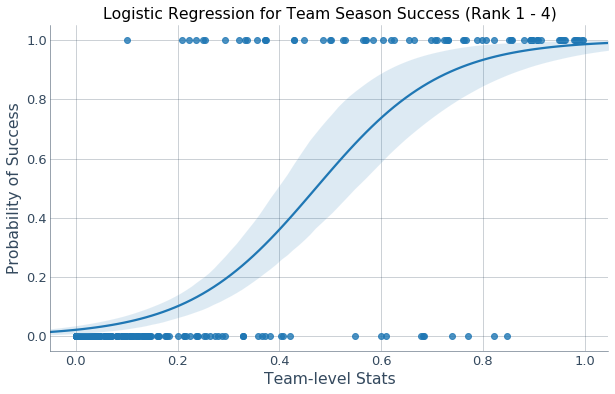

In [395]:
plot_X = selector.predict_proba(std_X)[:,1]

sns.regplot(x=plot_X, y=y, logistic=True)
plt.xlabel('Team-level Stats')
plt.ylabel('Probability of Success')
plt.title('Logistic Regression for Team Season Success (Rank 1 - 4)')
plt.savefig('assets/logreg_plot.png')
plt.show()


## 4.2 Random Forests

In [338]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23)

# standardize the features
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [339]:
clf = RandomForestClassifier(n_estimators = 100, random_state = 23)

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False)

In [340]:
y_pred = clf.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[38,  3],
       [ 8,  6]], dtype=int64)

In [347]:
team_rf_feature_importances = pd.DataFrame({'feature':features, 
                                            'importance':clf.feature_importances_}).sort_values('importance',
                                                                                                ascending = False)
team_rf_feature_importances[:10]

,feature,importance
10,2P%,0.124828
4,FG%,0.103992
1,PA/G,0.094179
9,2PA,0.062859
0,PS/G,0.058218
7,3P%,0.055547
13,FT%,0.049207
11,FT,0.042505
8,2P,0.037126
15,DRB,0.036277


In [350]:
rf_score = clf.score(X_test, y_test)
print('Model Accuracy: {}'.format(rf_score))

Model Accuracy: 0.8


In [351]:
kfold = KFold(n_splits=5, random_state=15)
results = cross_val_score(clf, std_X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

rf_score = results.mean()

Accuracy: 80.73% (3.37%)


## 4.3 XGBoost

In [352]:
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23)

# standardize the features
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

kfold = KFold(n_splits=5, random_state=23)

score_list = []

rates = np.arange(0.01, 0.11, 0.01)

for i in rates:

    gbm = xgb.XGBClassifier(max_depth=3, n_estimators=100, learning_rate = i)

    gbm.fit(X_train, y_train)

    score = cross_val_score(gbm, std_X, y, cv=kfold)
    score_list.append(score.mean())

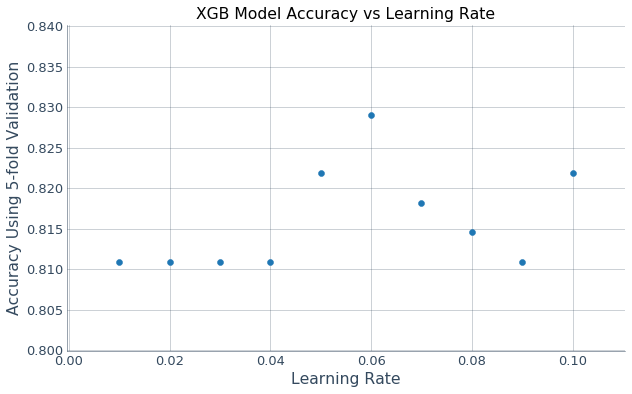

In [353]:
plt.scatter(rates, score_list)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy Using 5-fold Validation')
plt.title('XGB Model Accuracy vs Learning Rate')
plt.show()

In [354]:
xgboost_score = score_list[4] # 0.822

In [355]:
confusion_matrix(y_test, y_pred)

array([[38,  3],
       [ 8,  6]], dtype=int64)

In [356]:
y_pred = gbm.predict(X_test)
score = gbm.score(X_test, y_test)

gbm.score(X_test, y_test)

0.7818181818181819

In [357]:


kfold = KFold(n_splits=10, random_state=15)
results = cross_val_score(gbm, std_X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 83.68% (5.10%)


In [360]:
team_gbm_feature_importances = pd.DataFrame({'feature':features,
                                             'importance':gbm.feature_importances_}).sort_values('importance',
                                                                                                ascending = False)

# 5 Comparing Models

In [294]:
regressor_models = pd.DataFrame({'name':['OLS Regression','Random Forest','XGBoost'],
                                 'R-squared':[ols_rsq,rf_rsq, xgb_rsq]})
regressor_models

,name,R-squared
0,OLS Regression,0.434588
1,Random Forest,0.506655
2,XGBoost,0.517587


None of our models were especially impressive, but this points to a much bigger issue wih data science questions in general, and that is: do we have access to all the features? These models do their best to predict what a player would be paid based on their stats (of which we have many), 

In [196]:
classifier_models = pd.DataFrame({'name':['Logistic Regression','Random Forest','XGBoost'],
                                  'accuracy':[logreg_score, rf_score, xgboost_score]})
classifier_models

,name,accuracy
0,Logistic Regression,0.890909
1,Random Forest,0.807273
2,XGBoost,0.821818


So, we see here that sklearn's LogisticRegression gave us the best accuracy for predicting whether a team from the last decade might make the playoffs *with* a high seed (rank 1 through 4).<br><br>Critically, when we used the Recursive Feature Elimination with the logistic regression, we saw which features were the most important.


In [362]:
a = df.corr().sort_values('salary', ascending = False).loc[:,'salary'].index[1:11]

b = rf_feat_df.feature[:10]

c = xgb_feature_importances.iloc[:10,0]
d = select_results.feature[:10]
e = team_rf_feature_importances.feature[:10]
f = team_gbm_feature_importances.feature[:10]

final_df = pd.DataFrame([a,b,c,d,e,f], index = ['Correlates (Salary)',
                               'RandomForest (Salary)',
                               'XGBoost (Salary)',
                               'RFE (Team Success)',
                               'RandomForest (Team Success)',
                               'XGBoost (Team Success)']).T
final_df

,Correlates (Salary),RandomForest (Salary),XGBoost (Salary),RFE (Team Success),RandomForest (Team Success),XGBoost (Team Success)
0,PTS,Age,PER,PS/G,2P%,2P%
1,PER,PER,PTS,PA/G,FG%,PS/G
2,VORP,GS,Age,3PA,PA/G,3P%
3,WS,PTS,GS,FG%,2PA,PA/G
4,FG,USG%,USG%,3P,PS/G,FT%
5,OWS,FG,FG,FT,3P%,FT
6,USG%,16-3pt_A,TRB%,2P%,FT%,2PA
7,GS,PF,DRB%,FT%,FT,3P
8,FGA,MP,%Corner3_A,ORB,2P,FG
9,FT,FGA,AST%,2PA,DRB,3PA


To understand the above table simply: the first two columns give us the features that help us to understand and predict what a player will be paid (i.e. his "worth"). The third and final column tells us the features that best predict a team's success. In that column, we can throw out the first two, as Points Scored and Points Against are a given. This means that essentially, the most important predictor for team success is 3PA ("Three Pointers Attempted"), followed by Field Goal Percentage and "Three Pointers Made". As simple as it is to possibly state the conclusion: **shooting and making threes leads to success, but that's not what GMs are paying for.**